<a href="https://colab.research.google.com/github/gabelstapler6/QuickDrawClassification/blob/main/challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning challenge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Objective
The objective of this challenge is to develop a deep learning based classification method to classify images from [Google Quickdraw](https://quickdraw.withgoogle.com/data).


## Data 
Among all the available images, you will work on a dataset composed of 5 balanced classes, with 15000 training examples and 5000 test examples: baskets, eyes, glasses, rabbits and hands. The archive *Data_train_test.zip* contains the set of images, as well as two CSV files, giving the lists of images used for the training/test step. 

## Methodology
You can use any algorithm that seems relevant to you (MLP, CNN, LSTM, transfer Learning,...), or even create your own neural network ! Find a relevant methodology, evaluate several architectures (use of dropout, batch Normalisation, use of pretrained netorks with fine tuning... ), objective functions, optimizers.... Take a look at the influence of the parameters (learning rate, batch size, ...). Be imaginative !!


## Evaluation
You have to write a final report in a **jupyter notebook**. The code will be done in Python, the comments in Markdown. 
In this report, you will detail all the steps that led you to the final results, the code you produce, all the experiments you made (different architectures, different parameters, the way you measure the performance of your method,...) with **relevant** comments.

In order not to train all your models by myself, please save your **final** model using the [`save_weights`](https://keras.io/api/models/model_saving_apis/) method. For example:

`model = tf.keras.Sequential([tf.keras.layers.Dense(5, input_shape=(3,)),tf.keras.layers.Softmax()])`

`model.compile(...)`

`model.fit(...)`

`model.save_weights('mymodel.h5')`

Please provide the `.h5` file as well as the full jupyter notebook.



I have a validation set to validate your trained network. I will run your model on this dataset to measure the classification accuracy. 

To give the final mark, the following criteria will be used:
- I will rank you w.r.t. to the accuracy on the validation set. The ranking will provide a part (8/20) of the note (8 points for the best accuracy down to 2 points for the worst)
- The report will provide the remaining 12 points. I will assess the experiments you have made, the final model itself, the comments and the conclusions you have drawn, the results you  have obtained

The report, as well as the `.h5`file, are due **July 5th 2021** on the GRISP  platform.

## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import os.path
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns

from random import randrange

!pip install -q -U keras-tuner

import keras_tuner as kt

     |████████████████████████████████| 102kB 7.0MB/s 


## Parameters


In [ ]:
# Use the correct directory
data_dir = "/content/drive/MyDrive/DeepLearning/Challenge/Data_train_test/"
model_dir = "/content/drive/MyDrive/DeepLearning/Challenge/Models/"

classes = ["basket","eye","binoculars","rabbit","hand"]
num_classes = 5

image_width = 28
image_height = 28
image_channels = 3

batch_size = 40

## Retrieve the dataset(s)
The data specified in the two .csv files needs to be loaded into the memory.
One set for training the other for testing.

### Evaluating the approach for retrieving the datasets

The images need to be loaded from the Google Drive into the memory so that they can be processed by the neural net. There are some different approaches to do that.

#### First approach: "Flow from dataframe"

The Flow from dataframe is very easy to implement and understand. It loads the information from the .csv file and creates a generator object. When using the generator object for fitting the images are loaded from the drive and freed afterward. This method is very good when using large datasets so that the RAM does not get full. The creation of the generator object is very fast, but because the images are loaded during the fitting, the fitting needs a ton amounts of time.

##### Example code:

In [ ]:
if 0:
  datagen = ImageDataGenerator(rescale=1./255.)

  train_df = pd.read_csv(data_dir + 'train.csv')

  train_generator = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = data_dir + "images/",
    x_col = "relative_path",
    y_col = "class_label",
    batch_size = batch_size,
    seed = 42,
    shuffle = True,
    class_mode = "raw",
    target_size = (image_height, image_width)
  )

This approach was the first to be used to retrieve the dataset. It was a failure due to the extreme fitting duration. The evaluation of the model was not possible because the colab session timed out before even reaching  completion of the first epoch. A bug resulted the fitting to freeze at the last batch of the epoch. The bug was fixed when setting the "steps_per_epoch" and "validation_steps" parameters of the fit function manually. Another approach needs to be used. MNIST is also as large as our dataset so the RAM usage should not be a problem.

#### Second approach: "Numpy array"

This approach loads all images into a numpy array. This is basically the same as the MNIST dataset. The good part about this is that after reading all the images into the array, the array itself can be saved to a file. This saves a lot of time, because the reason for the long loading times is the reading of the image files from the GoogleDrive. The first time reading all the raw images from the drive and converting them into numpy arrays needed to be endured (~6h) but then the development of the model could start. The loading of the array data from the file is also extremely fast (less than 1 minute) compared to loading the images. The fitting is also really fast.

### Define some convenience functions

The images can be loaded from disk using the "relative_path" column of the .csv files and put into a numpy array (e.g. x_train.shape: (75000, 28, 28, 3)). The corresponding labels were retrieved using the "class_label" column. The keras function "load_img" returns a PIL image which is "automatically" converted into a numpy array when putting it into one.


In [ ]:
def preprocess_data(dataframe):
  dataframe_size = len(dataframe.relative_path)
  x = np.empty((dataframe_size, image_height, image_width, image_channels))
  y = np.empty(dataframe_size)
  print("Start loading images...")
  for i in range(0, dataframe_size):
    img = tf.keras.preprocessing.image.load_img(data_dir + "images/" + dataframe.relative_path[i], target_size=(image_height, image_width))
    x[i] = img
    y[i] = dataframe.class_label[i]
    if (i+1) % 100 == 0:
      print("Loaded " + str(i+1) + "/" + str(dataframe_size))
  # normalize the pixel values to float values between 0 and 1
  x = x / 255.0
  return x, y

The "retrieve_data" function is used for managing the saving and loading of the dataset to the disk as well as calling the "preprocess_data" function to load the images from the Google drive.

In [ ]:
def retrieve_data(dataframe, save_path_x, save_path_y):
  if os.path.isfile(save_path_x) & os.path.isfile(save_path_y):
    print("Found save files:\n" + save_path_x + "\n" + save_path_y)
    x = np.load(save_path_x)
    y = np.load(save_path_y)
    return x, y
  else:
    x, y = preprocess_data(dataframe)
    np.save(save_path_x, x)
    np.save(save_path_y, y)
    return x, y

### Loading the datasets into the memory

In [ ]:
train_df = pd.read_csv(data_dir + 'train.csv')

print("Retrieve train data:")
x_train, y_train = retrieve_data(train_df, data_dir + "npy/x_train.npy", data_dir + "npy/y_train.npy")

Retrieve train data:
Found save files:
/content/drive/MyDrive/DeepLearning/Challenge/Data_train_test/npy/x_train.npy
/content/drive/MyDrive/DeepLearning/Challenge/Data_train_test/npy/y_train.npy


In [ ]:
test_df = pd.read_csv(data_dir + 'test.csv')

print("Retrieve test data:")
x_test, y_test = retrieve_data(test_df, data_dir + "npy/x_test.npy", data_dir + "npy/y_test.npy")

Retrieve test data:
Found save files:
/content/drive/MyDrive/DeepLearning/Challenge/Data_train_test/npy/x_test.npy
/content/drive/MyDrive/DeepLearning/Challenge/Data_train_test/npy/y_test.npy


### Visualize the data


Plot some random images and their corresponding label from the training set to confirm the data.

In [ ]:
def visualize_data(x_data, y_data):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    rand = randrange(len(x_data))
    img = x_data[rand]
    plt.imshow(img)
    label = int(y_data[rand])
    plt.title(classes[label])
    plt.axis("off")

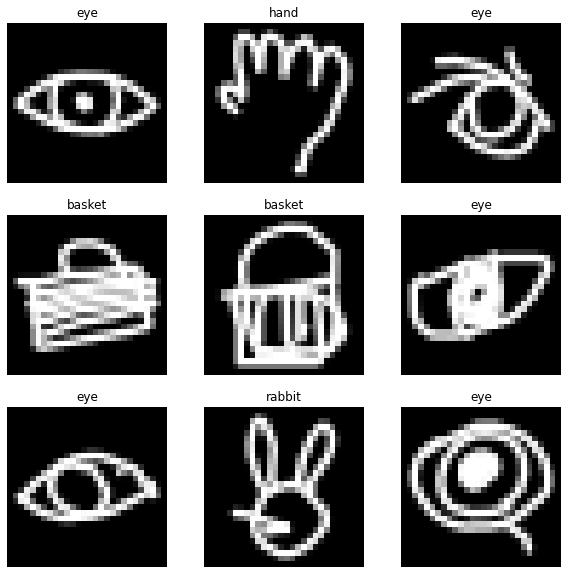

In [ ]:
visualize_data(x_train, y_train)

## Creating the classification model

#### Using a MLP architecture

The first architecture to try out the classification of the dataset was the MLP. The first Flatten layer is used to convert the 3-dimensional numpy arrays from the dataset into a 1-dimensional array. After those 3 Dense layers with the "tanh" activation function are used. At last, there is the last Dense layer with the output of 5 (number of classes in the dataset) and the "softmax" activation function to format the output into a probability distribution (float values from 0 to 1). The optimizer that is used is the Adam optimizer. The Adam optimizer is the best choice for a classification problem with a large number of training data because it speeds up the learning process. Because we have a multi class classification problem the best option to choose for the loss function is the "sparse_categorical_crossentropy".

For each model there is a "create_..._model" function. This is purely for convenience.

In [ ]:
def create_mlp_model(name):
  model = keras.Sequential(name=name)
  model.add(keras.layers.Flatten(input_shape=(image_height, image_width, image_channels)))
  model.add(keras.layers.Dense(units=128, activation="tanh"))
  model.add(keras.layers.Dense(units=64, activation="tanh"))
  model.add(keras.layers.Dense(units=64, activation="tanh"))
  model.add(keras.layers.Dense(units=5, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
mlp_model = create_mlp_model("mlp_model")
mlp_model.summary()

Model: "mlp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               301184    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 313,925
Trainable params: 313,925
Non-trainable params: 0
_________________________________________________________________


##### Train the model

Specifying some callback functions to be called during the fitting process
- EarlyStopping
  - Stop the fitting if the monitored value gets worse after the number of
  epochs specified in patience
  - Here the "val_loss" should be monitored because this value rises when the model starts to overfit
- CSVLogger
  - Save the training history into a file after each epoch

In [ ]:
def get_callbacks(name):
  callbacks = [
               tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4),
               keras.callbacks.CSVLogger(model_dir + name + ".history")
               ]
  return callbacks

This function is responsible for fitting the model as well as saving the trained weights to the Drive. If weights are already saved this function retrieves the weights and loads them into the model.

In [ ]:
def fit_model(model, epochs, force_fit=False, verbose=1):

  weights_path = model_dir + model.name + ".h5"
  history_path = model_dir + model.name + ".history"
  
  if not force_fit:
    if os.path.isfile(weights_path) & os.path.isfile(history_path):
      print("Found weights and training history for " + model.name + " at:\n" + weights_path + "\n" + history_path)
      model.load_weights(weights_path)
      return pd.read_csv(history_path)

  print("Fitting " + model.name + " ...\n")
  steps_per_epoch = len(x_train) // batch_size
  validation_steps = len(x_test) // batch_size

  history = model.fit(
      x = x_train,
      y = y_train,  
      steps_per_epoch = steps_per_epoch,
      validation_data = (x_test, y_test),
      validation_steps = validation_steps,
      epochs = epochs,
      batch_size = batch_size,
      shuffle = True,
      verbose = verbose,
      callbacks = get_callbacks(model.name)
  )

  model.save_weights(weights_path)

  print("Finished fitting!")
  return pd.DataFrame(history.history)

Calling the above defined function for fitting the MLP model.

In [ ]:
mlp_model_history = fit_model(mlp_model, epochs=20)

Found weights and training history for mlp_model at:
/content/drive/MyDrive/DeepLearning/Challenge/Models/mlp_model.h5
/content/drive/MyDrive/DeepLearning/Challenge/Models/mlp_model.history


##### Evaluate the model

This is a reusable function for plotting the accuracy of the training and the validation set, as well as the losses.

In [ ]:
def visualize_accuracy_and_loss(history, name=""):
  acc = history.accuracy
  val_acc = history.val_accuracy

  loss = history.loss
  val_loss = history.val_loss

  epochs_range = range(len(history.accuracy))

  plt.figure(figsize=(7, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label="Training Accuracy")
  plt.plot(epochs_range, val_acc, label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.title("Accuracy " + name)

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label="Training Loss")
  plt.plot(epochs_range, val_loss, label="Validation Loss")
  plt.legend(loc="upper right")
  plt.title("Loss " + name)
  plt.show()

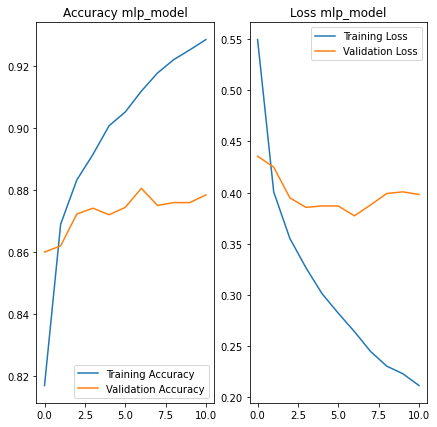

In [ ]:
visualize_accuracy_and_loss(mlp_model_history, mlp_model.name)

The shape of the curves tells us that the model quickly starts to overfit on the training set. The model cannot generalize because it depends too much on the training data.

Confusion Matrix

The confusion matrix shows the predicted and true labels for all classes in the specified dataset (x and y).

In [ ]:
def plot_confusion_matrix(model, x, y):
  y_true, y_pred = y, np.argmax(model.predict(x), axis=-1)
  cm = confusion_matrix(y_true, y_pred)

  fig, ax = plt.subplots(figsize=(7, 7))     
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, cmap="Greens", fmt="g")
  ax.set_xlabel("\nPredicted labels", fontsize=14)
  ax.set_ylabel("\nTrue labels", fontsize=14)
  ax.set_title("Confusion Matrix " + model.name)
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.show()

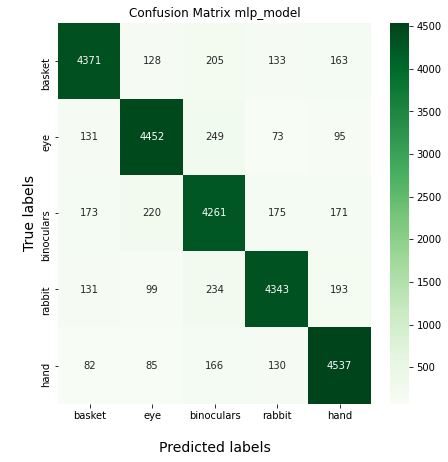

In [ ]:
plot_confusion_matrix(mlp_model, x_test, y_test)

At last, print the accuracy on the specified dataset.

In [ ]:
def get_final_accuracy(model, x, y):
  scores = model.evaluate(x=x, y=y, verbose=0)
  scores = round(scores[1]*100, 2)
  print("Final accuracy for " + model.name + ": " + str(scores) +  "%")
  return scores

In [ ]:
get_final_accuracy(mlp_model, x_test, y_test)

Final accuracy for mlp_model: 87.86%


87.86

The final accuracy on the test dataset is pretty good using the MLP model. To prevent overfitting Dropout layers can be added.

##### Adding Dropout

In [ ]:
def create_mlp_dropout_model(name):
  model = keras.Sequential(name=name)
  model.add(keras.layers.Flatten(input_shape=(image_height, image_width, image_channels)))
  model.add(keras.layers.Dense(units=128, activation="tanh"))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(units=64, activation="tanh"))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(units=64, activation="tanh"))
  model.add(keras.layers.Dense(units=5, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

The "process_model" function bundles all above functions into one call for convenience.

In [ ]:
def process_model(model, print_summary=True, epochs=10, force_fit=False, fitting_verbose=0):
  if print_summary:
    model.summary()
    print("\n")
  history = fit_model(model, epochs=epochs, force_fit=force_fit, verbose=fitting_verbose)
  print("\n")
  visualize_accuracy_and_loss(history, model.name)
  print("\n")
  plot_confusion_matrix(model, x_test, y_test)
  print("\n")
  return get_final_accuracy(model, x_test, y_test)

Model: "mlp_dropout_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               301184    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 5)           

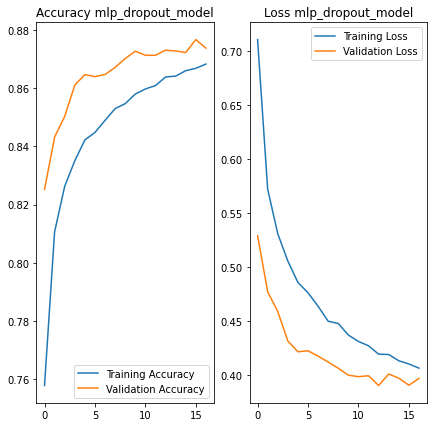

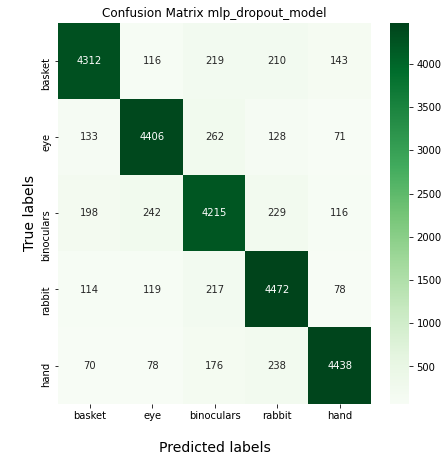



Final accuracy for mlp_dropout_model: 87.37%


In [ ]:
mlp_dropout_model = create_mlp_dropout_model("mlp_dropout_model")
process_model(mlp_dropout_model, epochs=20)

You can see that the shapes of the curves have changed drastically. The validation accuracy is now higher than the training accuracy, but the final accuracy is even a little bit worse than before. It can be concluded that using a MLP for classifying the QuickDraw dataset is not a good choice when it gets to getting the best results. The next best option is a CNN. The CNN can probably identify more patterns and generalize them better, because of the convolution layers.

#### Using a CNN architecture

Choosing the number of Convolution, Fully Connected, MaxPooling and Dropout is a hard choice, that why an approach for determining the number of layers needs to be used.

##### Number of Convolution layers

First the number of Convolution layers needs to be determined. The below code creates models with 1 to 10 stacked Convolution layers, fits them and saves the final accuracy into a dictionary for evaluation.

In [ ]:
conv_scores = {}
# up to 10 sequential convolution layers
for num_conv in range(1, 11):
  model = keras.Sequential(name = "cnn_model_" + str(num_conv) + "_conv")
  model.add(keras.layers.InputLayer(input_shape=(image_height, image_width, image_channels)))

  for i in range(0, num_conv):
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=64, activation="relu"))
  model.add(keras.layers.Dense(units=num_classes, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  fit_model(model, 20)
  score = get_final_accuracy(model, x_test, y_test)
  print("")

  conv_scores[model.name] = score

Found weights and training history for cnn_model_1_conv at:
/content/drive/MyDrive/DeepLearning/Challenge/Models/cnn_model_1_conv.h5
/content/drive/MyDrive/DeepLearning/Challenge/Models/cnn_model_1_conv.history
Final accuracy for cnn_model_1_conv: 92.36%

Found weights and training history for cnn_model_2_conv at:
/content/drive/MyDrive/DeepLearning/Challenge/Models/cnn_model_2_conv.h5
/content/drive/MyDrive/DeepLearning/Challenge/Models/cnn_model_2_conv.history
Final accuracy for cnn_model_2_conv: 93.36%

Found weights and training history for cnn_model_3_conv at:
/content/drive/MyDrive/DeepLearning/Challenge/Models/cnn_model_3_conv.h5
/content/drive/MyDrive/DeepLearning/Challenge/Models/cnn_model_3_conv.history
Final accuracy for cnn_model_3_conv: 93.93%

Found weights and training history for cnn_model_4_conv at:
/content/drive/MyDrive/DeepLearning/Challenge/Models/cnn_model_4_conv.h5
/content/drive/MyDrive/DeepLearning/Challenge/Models/cnn_model_4_conv.history
Final accuracy for cn

Visualizing the resulting scores and the corresponding models.

In [ ]:
def plot_dict(dict, y_min, y_max, figsize):
  keys = dict.keys()
  values = dict.values()

  plt.figure(figsize=figsize)
  plt.ylim(y_min, y_max)
  plt.bar(keys, values)
  plt.show()

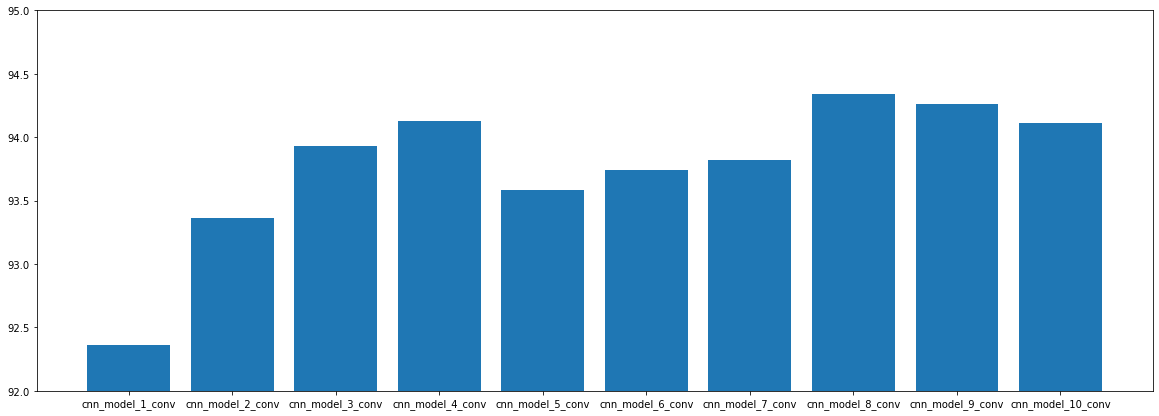

In [ ]:
plot_dict(conv_scores, 92, 95, (20,7))

The models with 4, 8 and 9 convolutions scored best. This method seems kind of random because all models scored nearly the same. Also, when looking at the histories of the models there are epochs with better accuracy. For the sake of experimenting, I will stick to these results.

##### Number of Fully Connected layers

 The next step is to find the optimal number of Fully Connected layers for the models. The models with 4, 8 and 9 convolutions scored best so the other configurations drop out. The below code creates the models and adds up to 5 Fully Connected layers.

In [ ]:
fc_scores = {}
conv_layers = [4,8,9]
for num_conv in conv_layers:
  # up to 5 fc layers
  for num_fc in range(2, 6):
    model = keras.Sequential(name = "cnn_model_" + str(num_conv) + "_conv_" + str(num_fc) + "_fc")
    model.add(keras.layers.InputLayer(input_shape=(image_height, image_width, image_channels)))

    for i in range(0, num_conv):
      model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
    
    model.add(keras.layers.Flatten())
    
    for i in range(0, num_fc):
      model.add(keras.layers.Dense(units=64, activation="relu"))

    model.add(keras.layers.Dense(units=num_classes, activation="softmax"))

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.summary()

    fit_model(model, 20)
    score = get_final_accuracy(model, x_test, y_test)
    print("")

    fc_scores[model.name] = score

Model: "cnn_model_4_conv_2_fc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
flatten_11 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                1605696   
_________________________________________________________________
dense_24 (Dense)             (None, 64)      

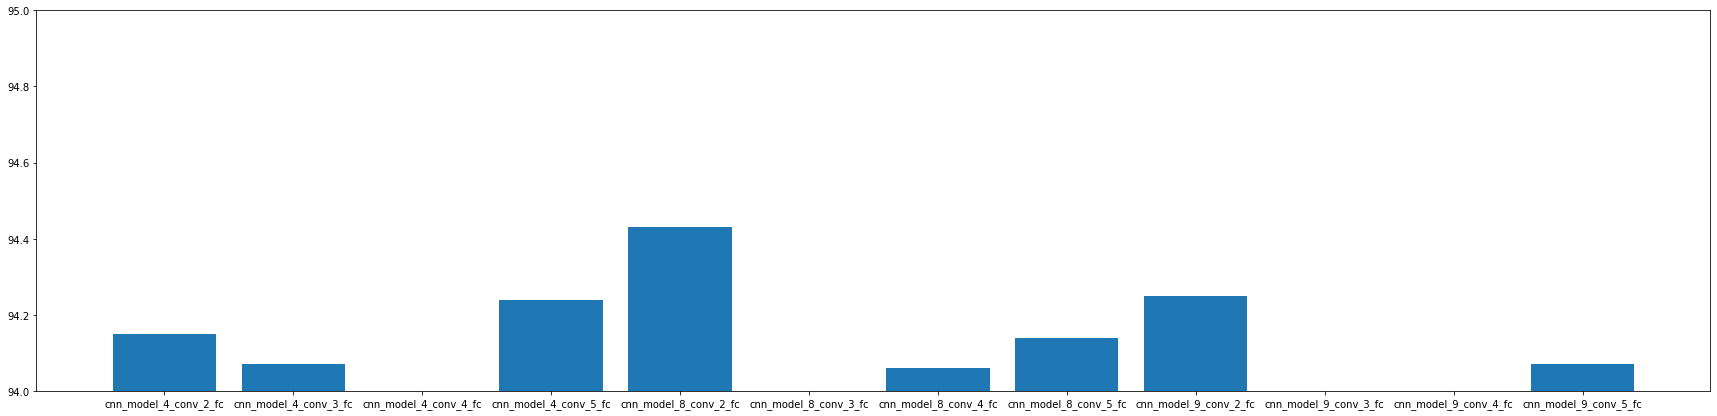

In [ ]:
plot_dict(scores, 94, 95, (30, 7))

The model with 8 Convolution and 2 Fully Connected layers scored best.

##### Adding MaxPooling and Dropout

The last step is to add Pooling and Dropout layers. At this step it is hard to create an algorithm to determine the best configurations because there are so many different options. After trying out many configurations of MaxPooling and Dropout layers the below code is the final result. Dropout after each "block" and in between the convolutions. MaxPooling also in between the Convolution layers.

In [ ]:
def create_cnn_model():
  model = keras.Sequential(name="cnn_model")

  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape=(image_height, image_width, image_channels)))
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))

  model.add(keras.layers.Dropout(rate=0.3))

  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))

  model.add(keras.layers.Dropout(rate=0.3))
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(units=64, activation="relu"))
  model.add(keras.layers.Dropout(rate=0.3))
  model.add(keras.layers.Dense(units=64, activation="relu"))
  model.add(keras.layers.Dropout(rate=0.3))

  model.add(keras.layers.Dense(units=num_classes, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  return model

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
dropout_32 (Dropout)         (None, 14, 14, 32)        0 

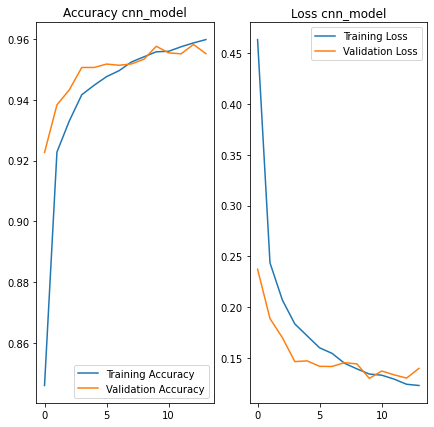

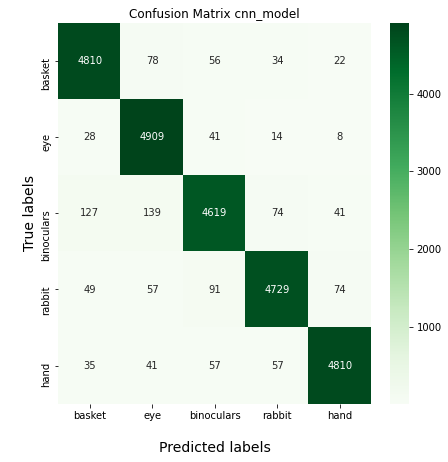



Final accuracy for cnn_model: 95.51%


95.51

In [ ]:
cnn_model = create_cnn_model()
process_model(cnn_model, epochs=20, fitting_verbose=1)

#### Tuning the hyperparameters of the CNN model

The layer architecture of the model is now finished. It is time to fine tune the parameters. For this the Hyperband tuner is used.

In [ ]:
def create_cnn_hypermodel(hp):
  model = keras.Sequential()

  hp_filters = hp.Int("conv1_filters", min_value=16, max_value=256, step=16)
  model.add(keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), padding="same", activation="relu", input_shape=(image_height, image_width, image_channels)))

  hp_filters = hp.Int("conv2_filters", min_value=16, max_value=256, step=16)
  model.add(keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), padding="same", activation="relu"))
  
  hp_filters = hp.Int("conv3_filters", min_value=16, max_value=256, step=16)
  model.add(keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), padding="same", activation="relu"))

  model.add(keras.layers.MaxPooling2D())

  hp_filters = hp.Int("conv4_filters", min_value=16, max_value=256, step=16)
  model.add(keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), padding="same", activation="relu"))

  hp_filters = hp.Int("conv5_filters", min_value=16, max_value=256, step=16)
  model.add(keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), padding="same", activation="relu"))

  hp_dropout = hp.Float("dropout1_rate", min_value=0.1, max_value=0.5, step=0.1)
  model.add(keras.layers.Dropout(rate=hp_dropout))

  hp_filters = hp.Int("conv6_filters", min_value=16, max_value=256, step=16)
  model.add(keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), padding="same", activation="relu"))

  model.add(keras.layers.MaxPooling2D())
  
  hp_filters = hp.Int("conv7_filters", min_value=16, max_value=256, step=16)
  model.add(keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), padding="same", activation="relu"))
  
  hp_filters = hp.Int("conv8_filters", min_value=16, max_value=256, step=16)
  model.add(keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), padding="same", activation="relu"))

  hp_dropout = hp.Float("dropout2_rate", min_value=0.1, max_value=0.5, step=0.1)
  model.add(keras.layers.Dropout(rate=hp_dropout))

  model.add(keras.layers.Flatten())

  hp_units = hp.Int("fc1_units", min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation="relu"))

  hp_dropout = hp.Float("dropout3_rate", min_value=0.1, max_value=0.5, step=0.1)
  model.add(keras.layers.Dropout(rate=hp_dropout))

  hp_units = hp.Int("fc2_units", min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation="relu"))

  hp_dropout = hp.Float("dropout4_rate", min_value=0.1, max_value=0.5, step=0.1)
  model.add(keras.layers.Dropout(rate=0.3))

  model.add(keras.layers.Dense(units=num_classes, activation="softmax"))

  hp_learning_rate = hp.Choice("learning_rate", values=[0.001, 0.0001])
  optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

  loss = keras.losses.SparseCategoricalCrossentropy()

  model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
  return model

The tuner uses an algorithm to quickly sort out the good parameters and finish the tuning in less time.

In [ ]:
tuner = kt.tuners.Hyperband(create_cnn_hypermodel,
                     objective="val_accuracy",
                     max_epochs=10,
                     factor=3,
                     directory=model_dir,
                     project_name="cnn_hypermodel")

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/DeepLearning/Challenge/Models/cnn_hypermodel/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/DeepLearning/Challenge/Models/cnn_hypermodel/tuner0.json


In [ ]:
tuner.search(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=get_callbacks("cnn_hypermodel"))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Oracle triggered exit


The Hyperband tuner eats up a lot of RAM so that the collab session terminates the runtime. Luckily the tuner saves all progress to the specified directory so that it can be rerun after the session exits.

In [ ]:
print("Best values:")
print("conv1_filters: " + str(best_hps.get("conv1_filters")))
print("conv2_filters: " + str(best_hps.get("conv2_filters")))
print("conv3_filters: " + str(best_hps.get("conv3_filters")))
print("conv4_filters: " + str(best_hps.get("conv4_filters")))
print("conv5_filters: " + str(best_hps.get("conv5_filters")))
print("conv6_filters: " + str(best_hps.get("conv6_filters")))
print("conv7_filters: " + str(best_hps.get("conv7_filters")))
print("conv8_filters: " + str(best_hps.get("conv8_filters")))

print("dropout1_rate: " + str(best_hps.get("dropout1_rate")))
print("dropout2_rate: " + str(best_hps.get("dropout2_rate")))
print("dropout3_rate: " + str(best_hps.get("dropout3_rate")))
print("dropout4_rate: " + str(best_hps.get("dropout4_rate")))

print("fc1_units: " + str(best_hps.get("fc1_units")))
print("fc2_units: " + str(best_hps.get("fc2_units")))
print("learning_rate: " + str(best_hps.get("learning_rate")))

Best values:
conv1_filters: 240
conv2_filters: 240
conv3_filters: 64
conv4_filters: 112
conv5_filters: 160
conv6_filters: 176
conv7_filters: 96
conv8_filters: 240
dropout1_rate: 0.2
dropout2_rate: 0.4
dropout3_rate: 0.2
dropout4_rate: 0.30000000000000004
fc1_units: 288
fc2_units: 448
learning_rate: 0.0001


#### Create the final model

The best parameters have been determined now the final model needs to be created.

In [ ]:
def create_final_model():
  model = keras.Sequential(name="final_model")

  model.add(keras.layers.Conv2D(filters=best_hps.get("conv1_filters"), kernel_size=(3,3), padding="same", activation="relu", input_shape=(image_height, image_width, image_channels)))
  model.add(keras.layers.Conv2D(filters=best_hps.get("conv2_filters"), kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.Conv2D(filters=best_hps.get("conv3_filters"), kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(filters=best_hps.get("conv4_filters"), kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.Conv2D(filters=best_hps.get("conv5_filters"), kernel_size=(3,3), padding="same", activation="relu"))

  model.add(keras.layers.Dropout(rate=best_hps.get("dropout1_rate")))

  model.add(keras.layers.Conv2D(filters=best_hps.get("conv6_filters"), kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(filters=best_hps.get("conv7_filters"), kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.Conv2D(filters=best_hps.get("conv8_filters"), kernel_size=(3,3), padding="same", activation="relu"))

  model.add(keras.layers.Dropout(rate=best_hps.get("dropout2_rate")))
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(units=best_hps.get("fc1_units"), activation="relu"))
  model.add(keras.layers.Dropout(rate=best_hps.get("dropout3_rate")))
  model.add(keras.layers.Dense(units=best_hps.get("fc2_units"), activation="relu"))
  model.add(keras.layers.Dropout(rate=best_hps.get("dropout4_rate")))

  model.add(keras.layers.Dense(units=num_classes, activation="softmax"))

  optimizer = keras.optimizers.Adam(learning_rate=best_hps.get("learning_rate"))

  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  return model

After fitting the model with 20 epochs, it could be seen that the best accuracy was achieved at the 8th epoch.

Model: "final_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 240)       6720      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 240)       518640    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 64)        138304    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 112)       64624     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 160)       161440    
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 160)       

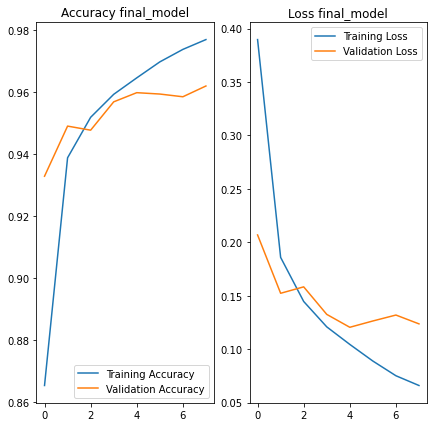

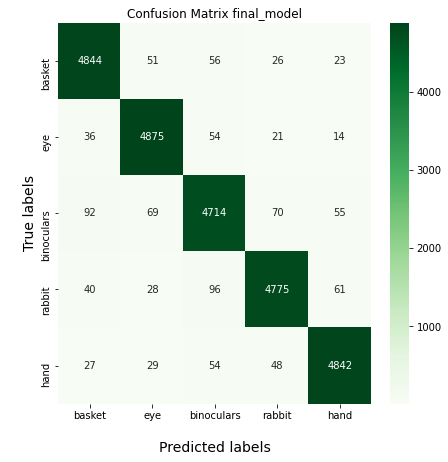



Final accuracy for final_model: 96.2%


96.2

In [ ]:
final_model = create_final_model()
process_model(final_model, epochs=8, fitting_verbose=1)

The curves tell us that the model starts to overfit on the training set, but the validation accuracy is the highest ever achieved so more tweaking seems unnecessary.

## Test the final model

To be sure that everything works fine, lets test the final model.

This function shuffles 2 arrays the same way and returns the shuffled copies.

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

To be sure test the final model on the shuffled test dataset.

In [ ]:
x_test_shuffled, y_test_shuffled = unison_shuffled_copies(x_test, y_test)

get_final_accuracy(final_model, x_test_shuffled, y_test_shuffled)

Final accuracy for final_model: 96.2%


96.2

Plot the prediction values as well as the image.

In [ ]:
def plot_prediction(predictions_array, true_label, img):
  plt.figure(figsize=(10,3))
  plt.subplot(1,2,1)

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                100*np.max(predictions_array),
                                classes[true_label]),
                                color=color)
  ax = plt.subplot(1,2,2)

  plt.grid(False)
  plt.xticks(range(5))
  ax.xaxis.set_ticklabels(classes)
  plt.yticks([])
  thisplot = plt.bar(range(5), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

  plt.show()


Convenience function to let the model predict on the image specified at "path_to_image".

In [ ]:
def test_model_with_one_img(path_to_image, true_label, model):
  img = tf.keras.preprocessing.image.load_img(
    path_to_image,
    target_size=(image_height, image_width)
  )

  img_array = np.empty((1, image_height, image_width, image_channels))
  img_array[0] = img

  img_array = img_array / 255.0

  predictions = model.predict(img_array)

  plot_prediction(predictions[0], true_label, img_array)

Let's test the model on self-drawn images. One for each class.

In [ ]:
def test_model_with_my_drawings(model):
  # index in array represents the corresponding class label (y)
  my_drawings_paths = [
                      data_dir + "my_basket.png",
                      data_dir + "my_eye.png",
                      data_dir + "my_binoculars.png",
                      data_dir + "my_rabbit.png",
                      data_dir + "my_hand.png"
  ]

  for i in range(len(my_drawings_paths)):
    test_model_with_one_img(my_drawings_paths[i], i, model)


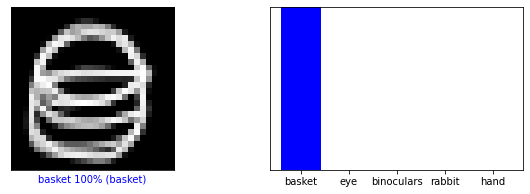

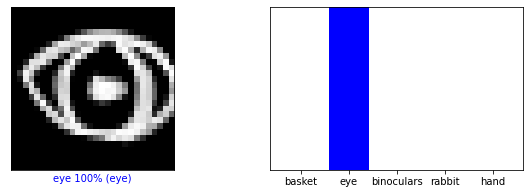

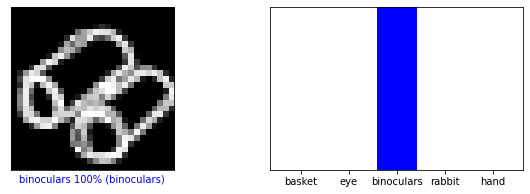

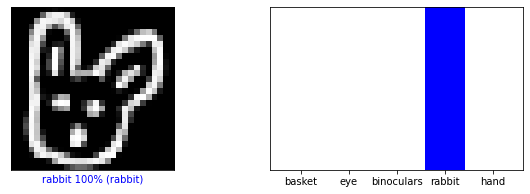

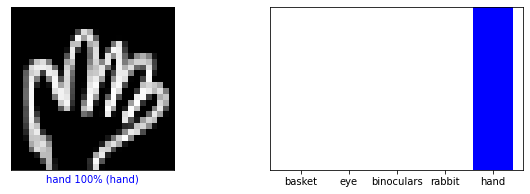

In [ ]:
test_model_with_my_drawings(final_model)

Each class delivered a 100% result. Probably the self-drawn images are classical examples.

## Conclusion

There are probably infinite possibilities for building and tweaking neural nets. The decision to stop at this point without diving deeper into different architectures or transfer learning is simply because of the deadline. The challenge made the task much more interesting, because of trying to achieve the best possible result.